In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import pickle
from tflearning.data.creator import create_datasetgenerator, DataConfig
import numpy as np
from omegaconf import OmegaConf
from dacite import from_dict
from ml_utilities.data.data_utils import show_image_grid, show_images
import pandas as pd
from tflearning.data.sample_selectors import count_samples_per_class

In [2]:
flowers_path = Path('/system/user/beck/pwbeck/projects/regularization/tflearning/outputs_scripts/prediction_depth/PD-flowers102-resnet18--230317_153444/prediction_depth_results.p')
cifar10_path = Path('/system/user/beck/pwbeck/projects/regularization/tflearning/outputs_scripts/prediction_depth/PD-cifar10_resnet18-pretrained--230317_124927/prediction_depth_results.p')

In [3]:
def load_dict(file):
    with open(file, 'rb') as f:
        return pickle.load(f)

In [4]:
cf_dict = load_dict(cifar10_path)
cf_dict['train'].keys()

dict_keys(['layer_accs', 'pred_depths', 'layer_preds', 'labels', 'num_classes', 'entropies'])

In [5]:
# create a pandas dataframe from the dictionary
cf_dict['train']['labels'].shape, cf_dict['train']['entropies'].shape

((50000,), (50000,))

In [18]:
cf_labels_entr = np.stack([cf_dict['train']['entropies'], cf_dict['train']['labels']], axis=1)

In [21]:
entr_labels_df = pd.DataFrame(cf_labels_entr, columns=['entropy', 'label'])
entr_labels_df.head()

,entropy,label
0,1.310784,6.0
1,1.581094,9.0
2,0.686962,9.0
3,1.149060,4.0
4,1.214890,1.0


In [36]:
label_sorted_entr = entr_labels_df.pivot(columns='label', values='entropy')
label_sorted_entr.head()

label,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
0,NaN,NaN,NaN,NaN,NaN,NaN,1.310784,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.581094
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.686962
3,NaN,NaN,NaN,NaN,1.14906,NaN,NaN,NaN,NaN,NaN
4,NaN,1.21489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


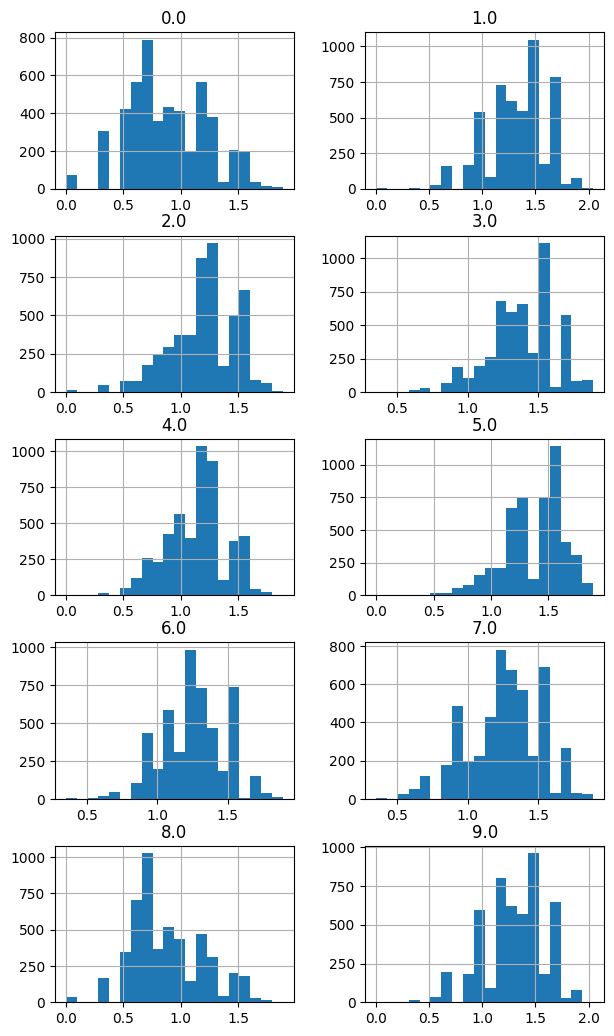

In [41]:
figs = label_sorted_entr.hist(bins=20, layout=(5,2), figsize=(1.5 * 12 * 1 / 2.54, 4 * 8 * 1 / 2.54))

In [46]:
label_sorted_entr[~label_sorted_entr[0.0].isnull()][0.0]

29       0.529706
30       0.936888
35       1.149060
49       1.273028
77       1.522955
           ...   
49921    0.936888
49930    1.310784
49941    1.522955
49992    1.149060
49994    0.964963
Name: 0.0, Length: 5000, dtype: float64

In [12]:
from typing import Dict

def get_class_sorted_entropy_array(entropies: np.ndarray, class_idxes: np.ndarray) -> Dict[int, pd.Series]:
    """Get entropies split by class idxes.
    """
    assert len(entropies) == len(class_idxes), f'entropies and class_labels must have same length, but are {len(entropies)} and {len(class_idxes)}'
    cf_labels_entropy = np.stack([entropies, class_idxes], axis=1)
    entr_labels_df = pd.DataFrame(cf_labels_entropy, columns=['entropy', 'label'])
    entropies_per_label_df = entr_labels_df.pivot(columns='label', values='entropy')
    class_sorted_entropy_arrays = {}
    for c in entropies_per_label_df.columns:
        class_idx = int(c)
        class_sorted_entropy_arrays[class_idx] = entropies_per_label_df[~entropies_per_label_df[c].isnull()][c]
    return class_sorted_entropy_arrays

In [57]:
cls_sorted_entropy_arrays = get_class_sorted_entropy_array(cf_dict['train']['entropies'], cf_dict['train']['labels'])

In [67]:
cls_sorted_entropy_arrays[0].sort_values(ascending=False).index[:6000]

Int64Index([ 6260, 45233, 32232, 40143,  2622,  7998, 22317,  5323, 40432,
             3102,
            ...
            25853, 32483, 48587, 26178,  6947,  1178, 31593, 18768, 18697,
            28865],
           dtype='int64', length=5000)

In [60]:
fraction = 0.2

total_num_samples = len(cf_dict['train']['entropies'])
num_classes = len(cls_sorted_entropy_arrays)

In [63]:
samples_per_class = int(fraction * total_num_samples / num_classes)
samples_per_class

1000

In [10]:
data_cfg = """
data:
  name: cifar10
  kwargs:
    data_root_path: /system/user/beck/pwbeck/data
    n_px: 224
  sample_selector:
    name: prediction_depth_class_balance
    kwargs:
      fraction: 0.2
      pred_results_file: /system/user/beck/pwbeck/projects/regularization/tflearning/outputs_scripts/prediction_depth/PD-cifar10_resnet18-pretrained--230317_124927/prediction_depth_results.p
      keep_highest: True
      restrict_n_samples: 1000
"""
data_cfg = OmegaConf.create(data_cfg)
data_cfg = from_dict(data=OmegaConf.to_container(data_cfg.data), data_class=DataConfig)
dsgen_cf10 = create_datasetgenerator(data_cfg=data_cfg)
dsgen_cf10.generate_dataset()
# show_images(dsgen_cf10.train_split, num_images=30, shuffle=True)

/system/apps/userenv/beck/subspaces/lib/python3.10/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


TypeError: only integer tensors of a single element can be converted to an index

In [5]:
len(dsgen_cf10.train_split)

500

In [6]:
count_samples_per_class(dsgen_cf10.train_split)

{0: 50, 1: 50, 2: 50, 3: 50, 4: 50, 5: 50, 6: 50, 7: 50, 8: 50, 9: 50}